In [184]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully for distributed systems performance analysis")

Libraries imported successfully for distributed systems performance analysis


In [185]:
def load_benchmark_data(base_path, strategy_type):
    """
    Load benchmark data for erasure coding or replication strategy
    
    Args:
        base_path: Path to benchmark results
        strategy_type: 'erasure' or 'replication'
    
    Returns:
        DataFrame with performance metrics
    """
    data_path = os.path.join(base_path, f"results_store/_final/{strategy_type}/write_avgnet")
    
    if not os.path.exists(data_path):
        print(f"Warning: Path {data_path} does not exist")
        return pd.DataFrame()
    
    results = []
    
    # Parse file naming pattern: _write_{payload}b_1vu_{bandwidth}mbit.json
    for filename in os.listdir(data_path):
        if filename.startswith('_write_') and filename.endswith('.json'):
            try:
                # Extract parameters from filename
                parts = filename.replace('_write_', '').replace('.json', '').split('_')
                payload_bytes = int(parts[0].replace('b', ''))
                bandwidth_mbit = int(parts[2].replace('mbit', ''))
                
                # Load JSON data
                with open(os.path.join(data_path, filename), 'r') as f:
                    data = json.load(f)
                
                # Extract performance metrics
                summary = data.get('summary', {})
                perf = summary.get('success_performance', {})
                reqs = summary.get('reqs', {})
                
                # Load CPU data
                cpu_file = f"cpu_avg_{payload_bytes}b_1vu_{bandwidth_mbit}mbit.txt"
                cpu_path = os.path.join(data_path, cpu_file)
                cpu_usage = 0
                if os.path.exists(cpu_path):
                    with open(cpu_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if 'Average CPU usage' in line:
                                cpu_usage = float(line.split(':')[1].strip())
                                break
                
                results.append({
                    'strategy': strategy_type,
                    'payload_bytes': payload_bytes,
                    'payload_kb': payload_bytes / 1024,
                    'bandwidth_mbit': bandwidth_mbit,
                    'avg_latency_ms': perf.get('avg', 0),
                    'min_latency_ms': perf.get('min', 0),
                    'max_latency_ms': perf.get('max', 0),
                    'p90_latency_ms': perf.get('p(90)', 0),
                    'p95_latency_ms': perf.get('p(95)', 0),
                    'median_latency_ms': perf.get('med', 0),
                    'request_rate': reqs.get('rate', 0),
                    'total_requests': reqs.get('count', 0),
                    'cpu_usage_percent': cpu_usage,
                    'throughput_ops_sec': reqs.get('rate', 0)
                })
                
            except (ValueError, KeyError, json.JSONDecodeError) as e:
                print(f"Error processing {filename}: {e}")
                continue
    
    return pd.DataFrame(results)

# Load data for both strategies
base_path = "/home/ostree/ta/implementasi/benchmark"
erasure_data = load_benchmark_data(base_path, "erasure")
replication_data = load_benchmark_data(base_path, "replication")

# Combine datasets
combined_data = pd.concat([erasure_data, replication_data], ignore_index=True)

In [186]:
# Data exploration and validation
# Overview
print(f"Erasure coding samples: {len(erasure_data)}")
print(f"Replication samples: {len(replication_data)}")
print(f"Total samples: {len(combined_data)}")

# Unique data
print("Unique payload sizes:", sorted(combined_data['payload_kb'].unique()))
print("Unique bandwidth values:", sorted(combined_data['bandwidth_mbit'].unique()))

# Metrics summary
print(combined_data.groupby('strategy')[['avg_latency_ms', 'throughput_ops_sec']].describe())

# Check for missing data
missing_data = combined_data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

# Basic statistics comparison
strategy_comparison = combined_data.groupby('strategy').agg({
    'avg_latency_ms': ['mean', 'std', 'min', 'max'],
    'throughput_ops_sec': ['mean', 'std', 'min', 'max'],
    'cpu_usage_percent': ['mean', 'std', 'min', 'max']
}).round(4)
print(strategy_comparison)

Erasure coding samples: 25
Replication samples: 25
Total samples: 50
Unique payload sizes: [np.float64(195.3125), np.float64(390.625), np.float64(585.9375), np.float64(781.25), np.float64(976.5625)]
Unique bandwidth values: [np.int64(10), np.int64(25), np.int64(40), np.int64(55), np.int64(70)]
            avg_latency_ms                                                    \
                     count         mean          std         min         25%   
strategy                                                                       
erasure               25.0   903.106263   746.303910  241.722793  457.927517   
replication           25.0  1363.821353  1644.737184  151.345583  445.896458   

                                                  throughput_ops_sec  \
                    50%          75%          max              count   
strategy                                                               
erasure      669.386850   975.910794  3282.157200               25.0   
replication  790

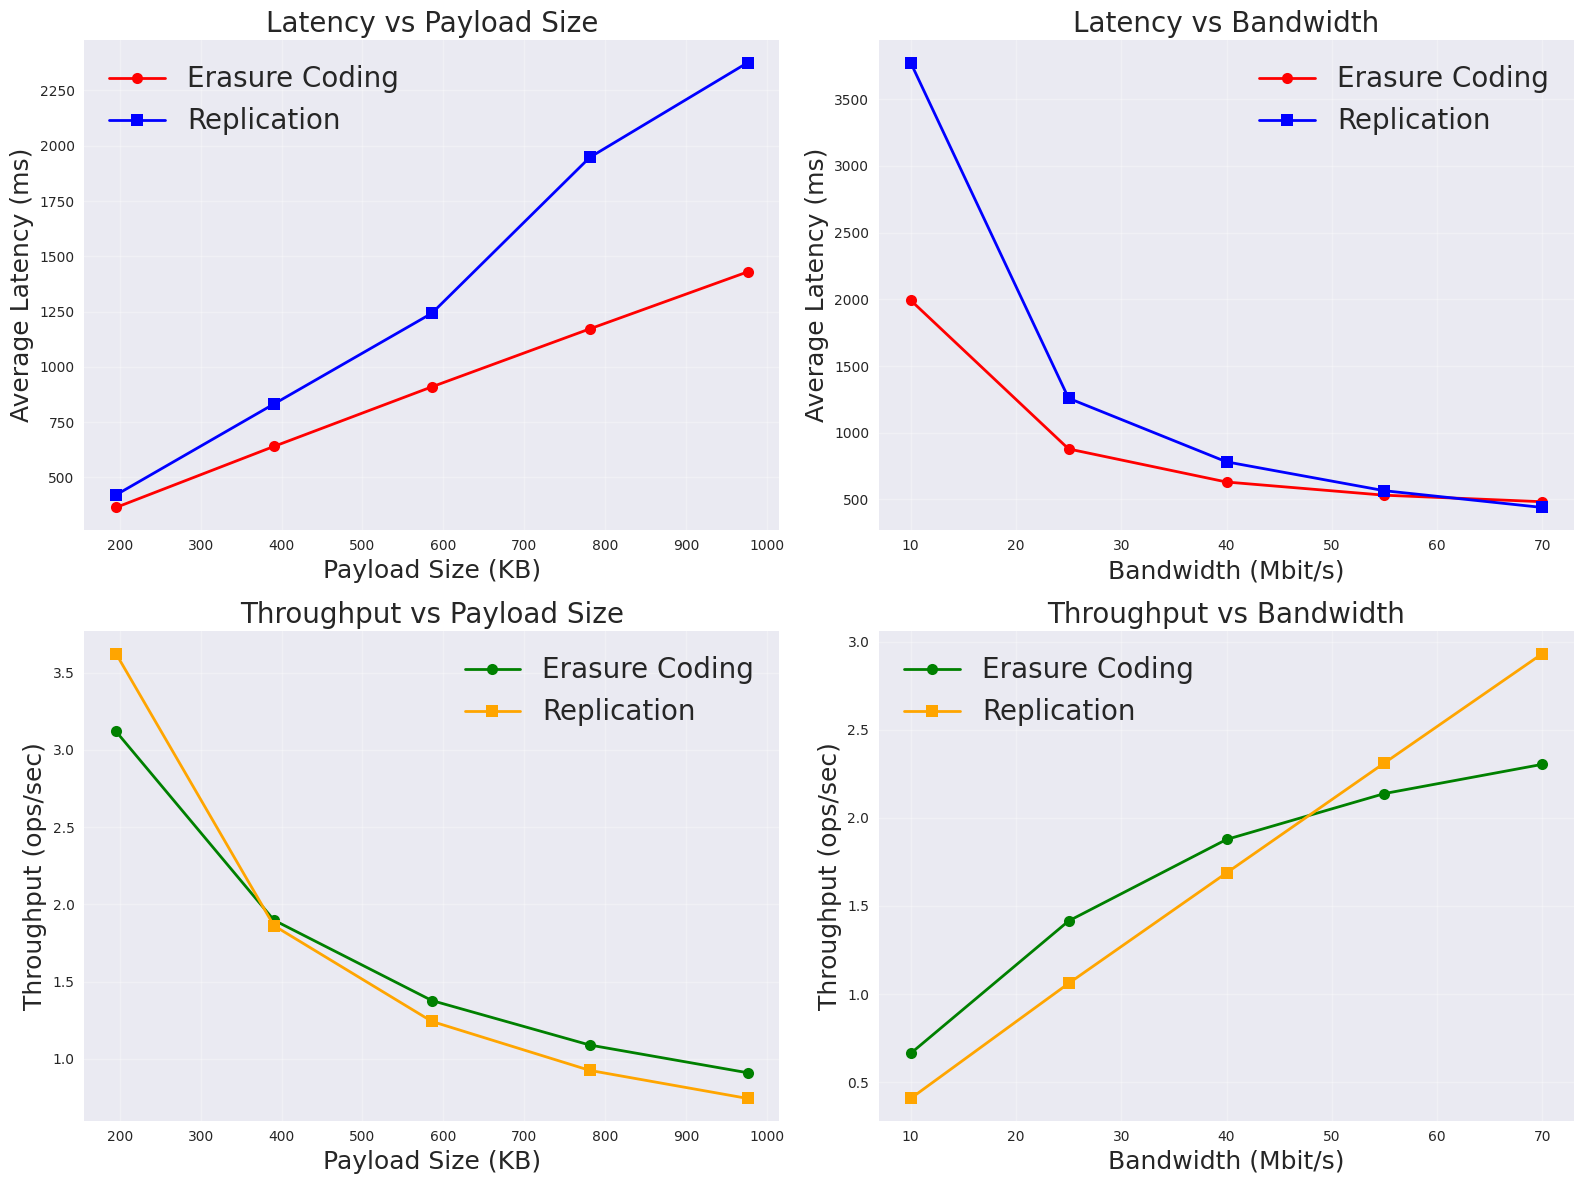

In [187]:
# Calculate performance ratios between erasure coding and replication
def calculate_performance_ratios(erasure_df, replication_df):
    """
    Calculate performance ratios between erasure coding and replication
    for matching bandwidth and payload configurations
    """
    ratios = []
    
    for _, ec_row in erasure_df.iterrows():
        # Find matching replication configuration
        matching_rep = replication_df[
            (replication_df['payload_kb'] == ec_row['payload_kb']) &
            (replication_df['bandwidth_mbit'] == ec_row['bandwidth_mbit'])
        ]
        
        if not matching_rep.empty:
            rep_row = matching_rep.iloc[0]
            
            # Calculate performance ratios for latency and throughput only
            latency_ratio = ec_row['avg_latency_ms'] / rep_row['avg_latency_ms']
            throughput_ratio = ec_row['throughput_ops_sec'] / rep_row['throughput_ops_sec']
            cpu_ratio = ec_row['cpu_usage_percent'] / rep_row['cpu_usage_percent'] if rep_row['cpu_usage_percent'] > 0 else 1
            
            ratios.append({
                'payload_kb': ec_row['payload_kb'],
                'bandwidth_mbit': ec_row['bandwidth_mbit'],
                'latency_ratio_ec_to_rep': latency_ratio,
                'throughput_ratio_ec_to_rep': throughput_ratio,
                'cpu_ratio_ec_to_rep': cpu_ratio,
                'ec_latency': ec_row['avg_latency_ms'],
                'rep_latency': rep_row['avg_latency_ms'],
                'ec_throughput': ec_row['throughput_ops_sec'],
                'rep_throughput': rep_row['throughput_ops_sec']
            })
    
    return pd.DataFrame(ratios)

# Calculate ratios
ratio_data = calculate_performance_ratios(erasure_data, replication_data)

# Create visualization focused on latency and throughput
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Latency comparison by payload size
ax1 = axes[0, 0]
payload_sizes = sorted(ratio_data['payload_kb'].unique())
ec_latencies = [ratio_data[ratio_data['payload_kb'] == p]['ec_latency'].mean() for p in payload_sizes]
rep_latencies = [ratio_data[ratio_data['payload_kb'] == p]['rep_latency'].mean() for p in payload_sizes]

ax1.plot(payload_sizes, ec_latencies, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax1.plot(payload_sizes, rep_latencies, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Payload Size (KB)', fontsize=18)
ax1.set_ylabel('Average Latency (ms)', fontsize=18)
ax1.set_title('Latency vs Payload Size', fontsize=20)
ax1.legend(fontsize=20)
ax1.grid(True, alpha=0.3)

# 2. Latency comparison by bandwidth
ax2 = axes[0, 1]
bandwidths = sorted(ratio_data['bandwidth_mbit'].unique())
ec_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_latency'].mean() for b in bandwidths]
rep_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_latency'].mean() for b in bandwidths]

ax2.plot(bandwidths, ec_latency_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax2.plot(bandwidths, rep_latency_bw, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Bandwidth (Mbit/s)', fontsize=18)
ax2.set_ylabel('Average Latency (ms)', fontsize=18)
ax2.set_title('Latency vs Bandwidth', fontsize=20)
ax2.legend(fontsize=20)
ax2.grid(True, alpha=0.3)

# 3. Throughput comparison by payload size
ax3 = axes[1, 0]
ec_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['ec_throughput'].mean() for p in payload_sizes]
rep_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['rep_throughput'].mean() for p in payload_sizes]

ax3.plot(payload_sizes, ec_throughputs, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax3.plot(payload_sizes, rep_throughputs, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax3.set_xlabel('Payload Size (KB)', fontsize=18)
ax3.set_ylabel('Throughput (ops/sec)', fontsize=18)
ax3.set_title('Throughput vs Payload Size', fontsize=20)
ax3.legend(fontsize=20)
ax3.grid(True, alpha=0.3)

# 4. Throughput comparison by bandwidth
ax4 = axes[1, 1]
ec_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_throughput'].mean() for b in bandwidths]
rep_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_throughput'].mean() for b in bandwidths]

ax4.plot(bandwidths, ec_throughput_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax4.plot(bandwidths, rep_throughput_bw, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax4.set_xlabel('Bandwidth (Mbit/s)', fontsize=18)
ax4.set_ylabel('Throughput (ops/sec)', fontsize=18)
ax4.set_title('Throughput vs Bandwidth', fontsize=20)
ax4.legend(fontsize=20)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

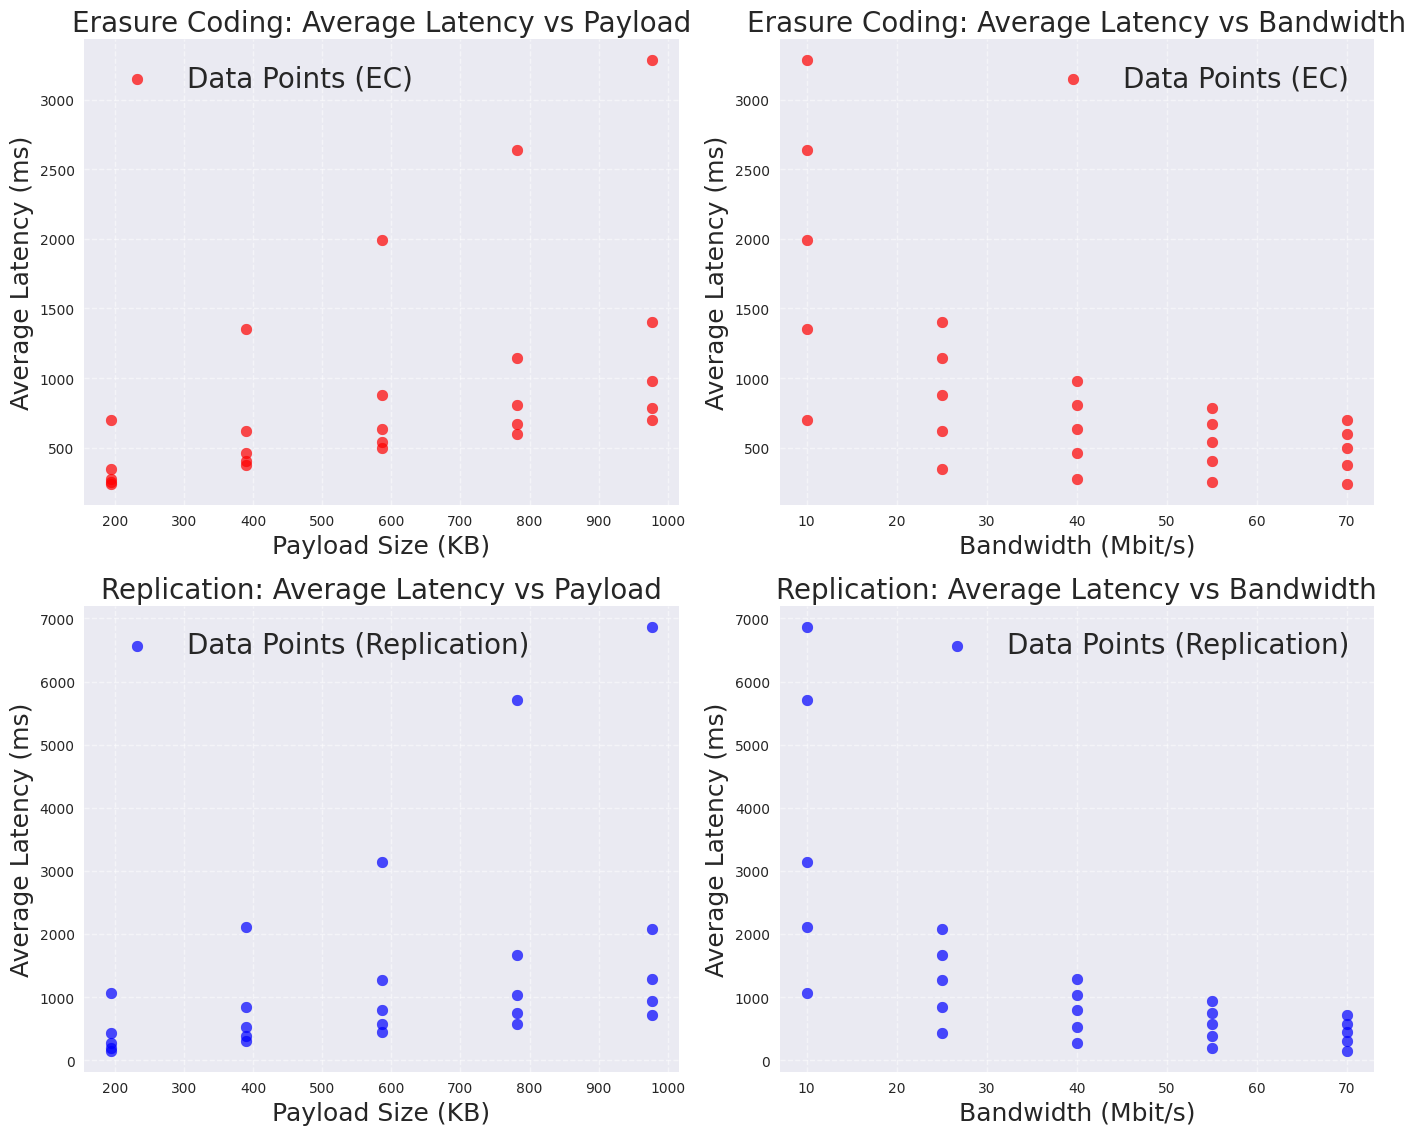

In [188]:
# Extract data
ec_data = erasure_data.copy()
rep_data = replication_data.copy()

# --- Scatter Plot ---
# Prepare visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. EC: Average Latency vs Payload
ax1 = axes[0, 0]
ax1.scatter(ec_data['payload_kb'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points (EC)')
ax1.set_xlabel('Payload Size (KB)', fontsize=18)
ax1.set_ylabel('Average Latency (ms)', fontsize=18)
ax1.set_title('Erasure Coding: Average Latency vs Payload', fontsize=20)
ax1.legend(fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)

# 2. EC: Average Latency vs Bandwidth
ax2 = axes[0, 1]
ax2.scatter(ec_data['bandwidth_mbit'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points (EC)')
ax2.set_xlabel('Bandwidth (Mbit/s)', fontsize=18)
ax2.set_ylabel('Average Latency (ms)', fontsize=18)
ax2.set_title('Erasure Coding: Average Latency vs Bandwidth', fontsize=20)
ax2.legend(fontsize=20)
ax2.grid(True, linestyle='--', alpha=0.5)

# 3. Replication: Average Latency vs Payload
ax3 = axes[1, 0]
ax3.scatter(rep_data['payload_kb'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points (Replication)')
ax3.set_xlabel('Payload Size (KB)', fontsize=18)
ax3.set_ylabel('Average Latency (ms)', fontsize=18)
ax3.set_title('Replication: Average Latency vs Payload', fontsize=20)
ax3.legend(fontsize=20)
ax3.grid(True, linestyle='--', alpha=0.5)

# 4. Replication: Average Latency vs Bandwidth
ax4 = axes[1, 1]
ax4.scatter(rep_data['bandwidth_mbit'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points (Replication)')
ax4.set_xlabel('Bandwidth (Mbit/s)', fontsize=18)
ax4.set_ylabel('Average Latency (ms)', fontsize=18)
ax4.set_title('Replication: Average Latency vs Bandwidth', fontsize=20)
ax4.legend(fontsize=20)
ax4.grid(True, linestyle='--', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ridge Regression R² - EC: 0.780, REP: 0.729
Latency difference range: -2140.32 to 356.69 ms


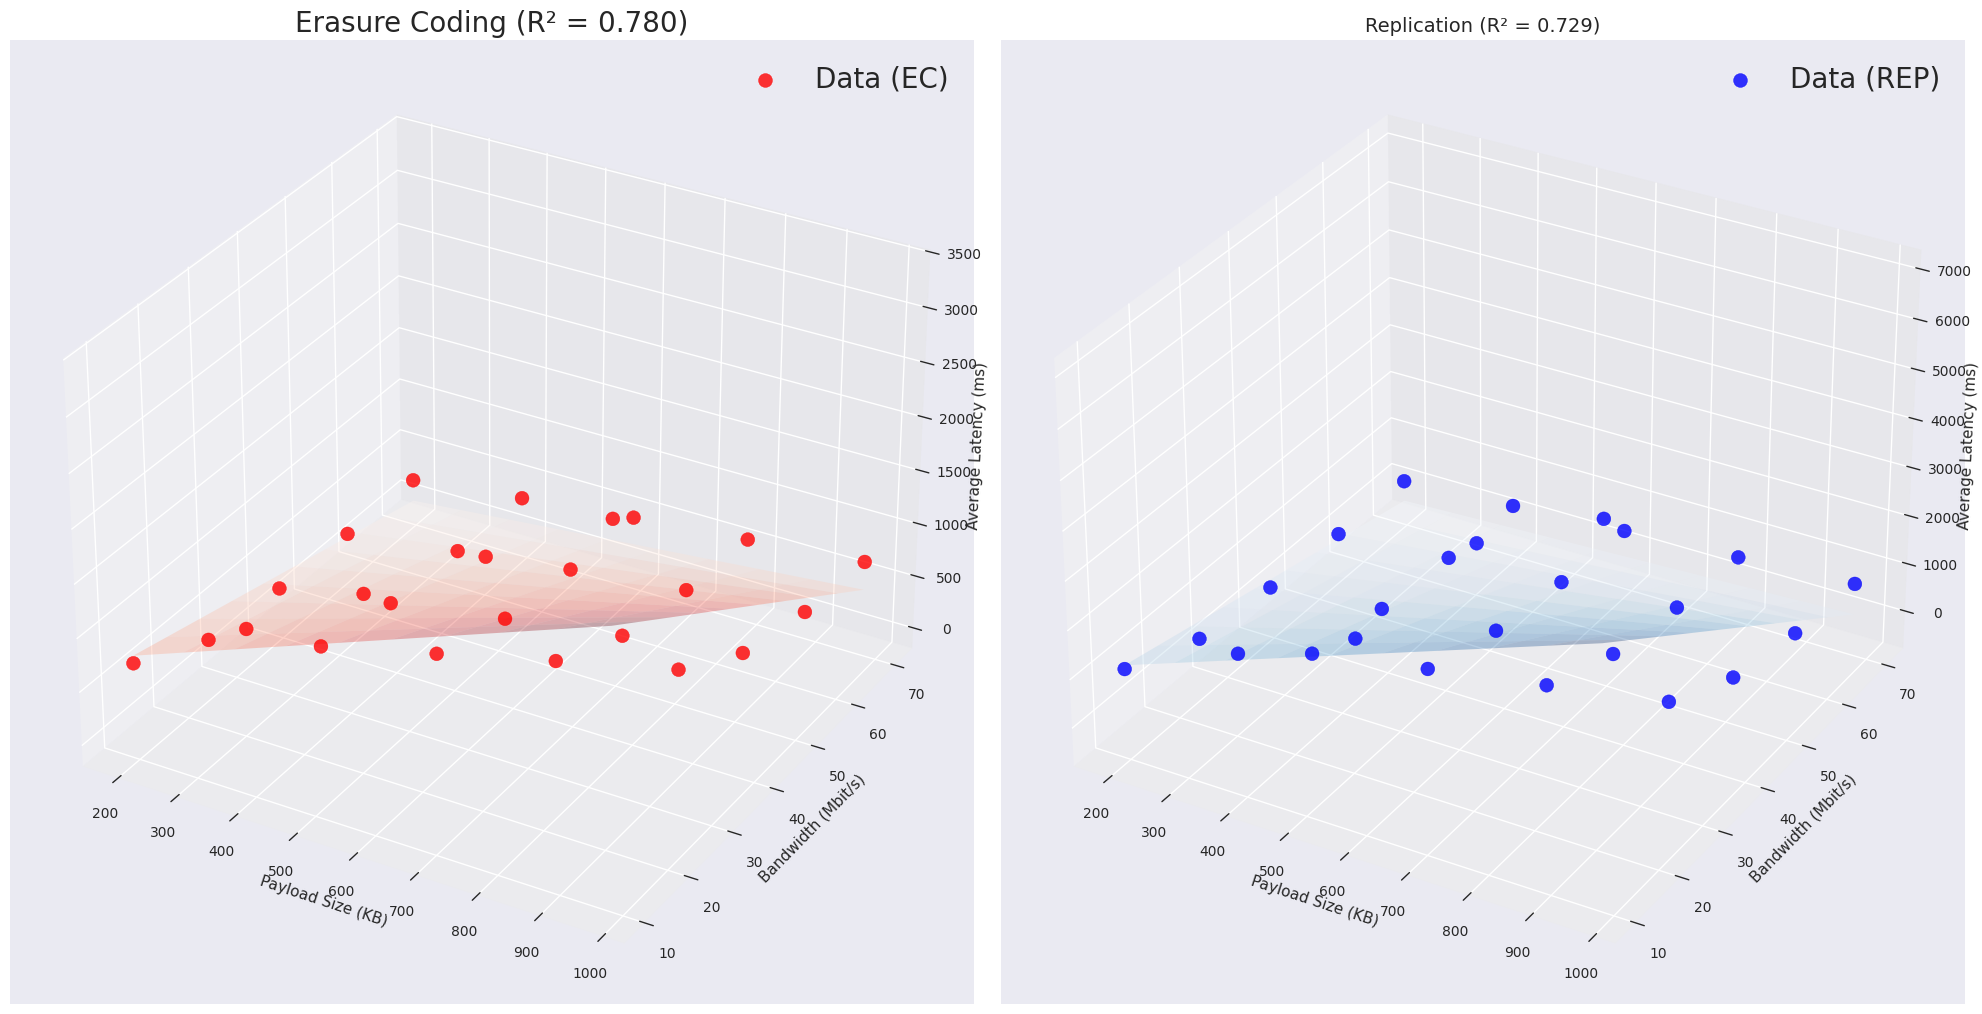

In [189]:
# Extract data
ec_data = erasure_data.copy()
rep_data = replication_data.copy()

# Check actual combinations available
ec_combinations = set(zip(ec_data['payload_kb'], ec_data['bandwidth_mbit']))
rep_combinations = set(zip(rep_data['payload_kb'], rep_data['bandwidth_mbit']))
common_combinations = ec_combinations.intersection(rep_combinations)

# Use only the actual data ranges for proper modeling
P_range_actual = sorted(list(set(ec_data['payload_kb'])))
B_range_actual = sorted(list(set(ec_data['bandwidth_mbit'])))

# Prepare data for both strategies
features = ['payload_kb', 'bandwidth_mbit']
target = 'avg_latency_ms'

X_ec = ec_data[features].copy()
X_rep = rep_data[features].copy()

# Add interaction term manually (P * B) - this captures the important interaction
X_ec['payload_bandwidth'] = X_ec['payload_kb'] * X_ec['bandwidth_mbit']
X_rep['payload_bandwidth'] = X_rep['payload_kb'] * X_rep['bandwidth_mbit']

y_ec = ec_data[target]
y_rep = rep_data[target]

# Use Ridge regression to prevent overfitting (regularization for sparse data)
scaler_ec = StandardScaler()
scaler_rep = StandardScaler()

X_ec_scaled = scaler_ec.fit_transform(X_ec)
X_rep_scaled = scaler_rep.fit_transform(X_rep)

# Ridge regression with proper regularization
ridge_ec = Ridge(alpha=1.0)
ridge_rep = Ridge(alpha=1.0)

ridge_ec.fit(X_ec_scaled, y_ec)
ridge_rep.fit(X_rep_scaled, y_rep)

# Calculate R² for the Ridge models
ec_r2_ridge = ridge_ec.score(X_ec_scaled, y_ec)
rep_r2_ridge = ridge_rep.score(X_rep_scaled, y_rep)

print(f"Ridge Regression R² - EC: {ec_r2_ridge:.3f}, REP: {rep_r2_ridge:.3f}")

# Create grid only within actual data bounds (no extrapolation)
P_grid, B_grid = np.meshgrid(P_range_actual, B_range_actual)
grid_points = np.c_[P_grid.ravel(), B_grid.ravel()]

# Add interaction term
grid_interaction = (P_grid * B_grid).ravel()
grid_features = np.column_stack([grid_points, grid_interaction])

# Scale and predict using the models
grid_features_ec_scaled = scaler_ec.transform(grid_features)
grid_features_rep_scaled = scaler_rep.transform(grid_features)

L_ec = ridge_ec.predict(grid_features_ec_scaled).reshape(P_grid.shape)
L_rep = ridge_rep.predict(grid_features_rep_scaled).reshape(P_grid.shape)

# Calculate difference (no more artificial oscillations)
L_diff = L_ec - L_rep

print(f"Latency difference range: {L_diff.min():.2f} to {L_diff.max():.2f} ms")

# --- 3D VISUALIZATION ---
fig = plt.figure(figsize=(20, 10))

# Plot for Erasure Coding
ax1 = fig.add_subplot(121, projection='3d')

# Plot actual data points
ax1.scatter(X_ec['payload_kb'], X_ec['bandwidth_mbit'], y_ec, color='red', alpha=0.8, s=100, label='Data (EC)')

# Create smooth surface for actual data points only
payload_range_fine = np.linspace(min(P_range_actual), max(P_range_actual), 10)
bandwidth_range_fine = np.linspace(min(B_range_actual), max(B_range_actual), 10)
P_fine, B_fine = np.meshgrid(payload_range_fine, bandwidth_range_fine)

# Predict for fine grid
grid_fine = np.c_[P_fine.ravel(), B_fine.ravel()]
grid_fine_interaction = (P_fine * B_fine).ravel()
grid_fine_features = np.column_stack([grid_fine, grid_fine_interaction])
grid_fine_scaled = scaler_ec.transform(grid_fine_features)

L_ec_surface = ridge_ec.predict(grid_fine_scaled).reshape(P_fine.shape)

ax1.plot_surface(P_fine, B_fine, L_ec_surface, alpha=0.3, cmap='Reds')

ax1.set_title(f'Erasure Coding (R² = {ec_r2_ridge:.3f})', fontsize=20)
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Bandwidth (Mbit/s)')
ax1.set_zlabel('Average Latency (ms)')
ax1.legend(fontsize=20)

# Plot for Replication
ax2 = fig.add_subplot(122, projection='3d')

# Plot actual data points
ax2.scatter(X_rep['payload_kb'], X_rep['bandwidth_mbit'], y_rep, color='blue', alpha=0.8, s=100, label='Data (REP)')

# Predict for fine grid
grid_fine_scaled_rep = scaler_rep.transform(grid_fine_features)
L_rep_surface = ridge_rep.predict(grid_fine_scaled_rep).reshape(P_fine.shape)

ax2.plot_surface(P_fine, B_fine, L_rep_surface, alpha=0.3, cmap='Blues')

ax2.set_title(f'Replication (R² = {rep_r2_ridge:.3f})', fontsize=14)
ax2.set_xlabel('Payload Size (KB)')
ax2.set_ylabel('Bandwidth (Mbit/s)')
ax2.set_zlabel('Average Latency (ms)')
ax2.legend(fontsize=20)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [190]:
# Get coefficients from the Ridge models (from previous cell)
ec_coefficients_ridge = ridge_ec.coef_
ec_intercept_ridge = ridge_ec.intercept_
rep_coefficients_ridge = ridge_rep.coef_
rep_intercept_ridge = ridge_rep.intercept_

# Feature names for Ridge model: [payload_kb, bandwidth_mbit, payload_bandwidth]
ridge_feature_names = ['payload_kb', 'bandwidth_mbit', 'payload_bandwidth']

print("\nRidge regression model structure:")
print("Latency = beta_0 + beta_1*P_scaled + beta_2*B_scaled + beta_3*(P*B)_scaled")
print("where P_scaled, B_scaled, (P*B)_scaled are standardized features")
    
def display_ridge_formula(strategy_name, intercept, coefficients, feature_names, scaler):
    print(f"\n{strategy_name} Strategy (Ridge Regression):")
    print(f"Intercept (beta_0): {intercept:.6f}")
    
    print(f"\nSubstituting Ridge coefficients:")
    print(f"Latency = {intercept:.6f}", end="")
    
    for i, (feature, coef) in enumerate(zip(feature_names, coefficients)):
        if abs(coef) > 1e-10:
            sign = "+" if coef >= 0 else "-"
            abs_coef = abs(coef)
            
            if feature == "payload_kb":
                print(f" {sign} {abs_coef:.6f}*P_scaled", end="")
            elif feature == "bandwidth_mbit":
                print(f" {sign} {abs_coef:.6f}*B_scaled", end="")
            elif feature == "payload_bandwidth":
                print(f" {sign} {abs_coef:.6f}*(P*B)_scaled", end="")
    
    print()  # New line

# Display formulas for both strategies
display_ridge_formula("Erasure Coding", ec_intercept_ridge, ec_coefficients_ridge, 
                     ridge_feature_names, scaler_ec)
display_ridge_formula("Replication", rep_intercept_ridge, rep_coefficients_ridge, 
                     ridge_feature_names, scaler_rep)


Ridge regression model structure:
Latency = beta_0 + beta_1*P_scaled + beta_2*B_scaled + beta_3*(P*B)_scaled
where P_scaled, B_scaled, (P*B)_scaled are standardized features

Erasure Coding Strategy (Ridge Regression):
Intercept (beta_0): 903.106263

Substituting Ridge coefficients:
Latency = 903.106263 + 633.019533*P_scaled - 153.347506*B_scaled - 449.584942*(P*B)_scaled

Replication Strategy (Ridge Regression):
Intercept (beta_0): 1363.821353

Substituting Ridge coefficients:
Latency = 1363.821353 + 1365.655624*P_scaled - 234.038869*B_scaled - 1132.316852*(P*B)_scaled


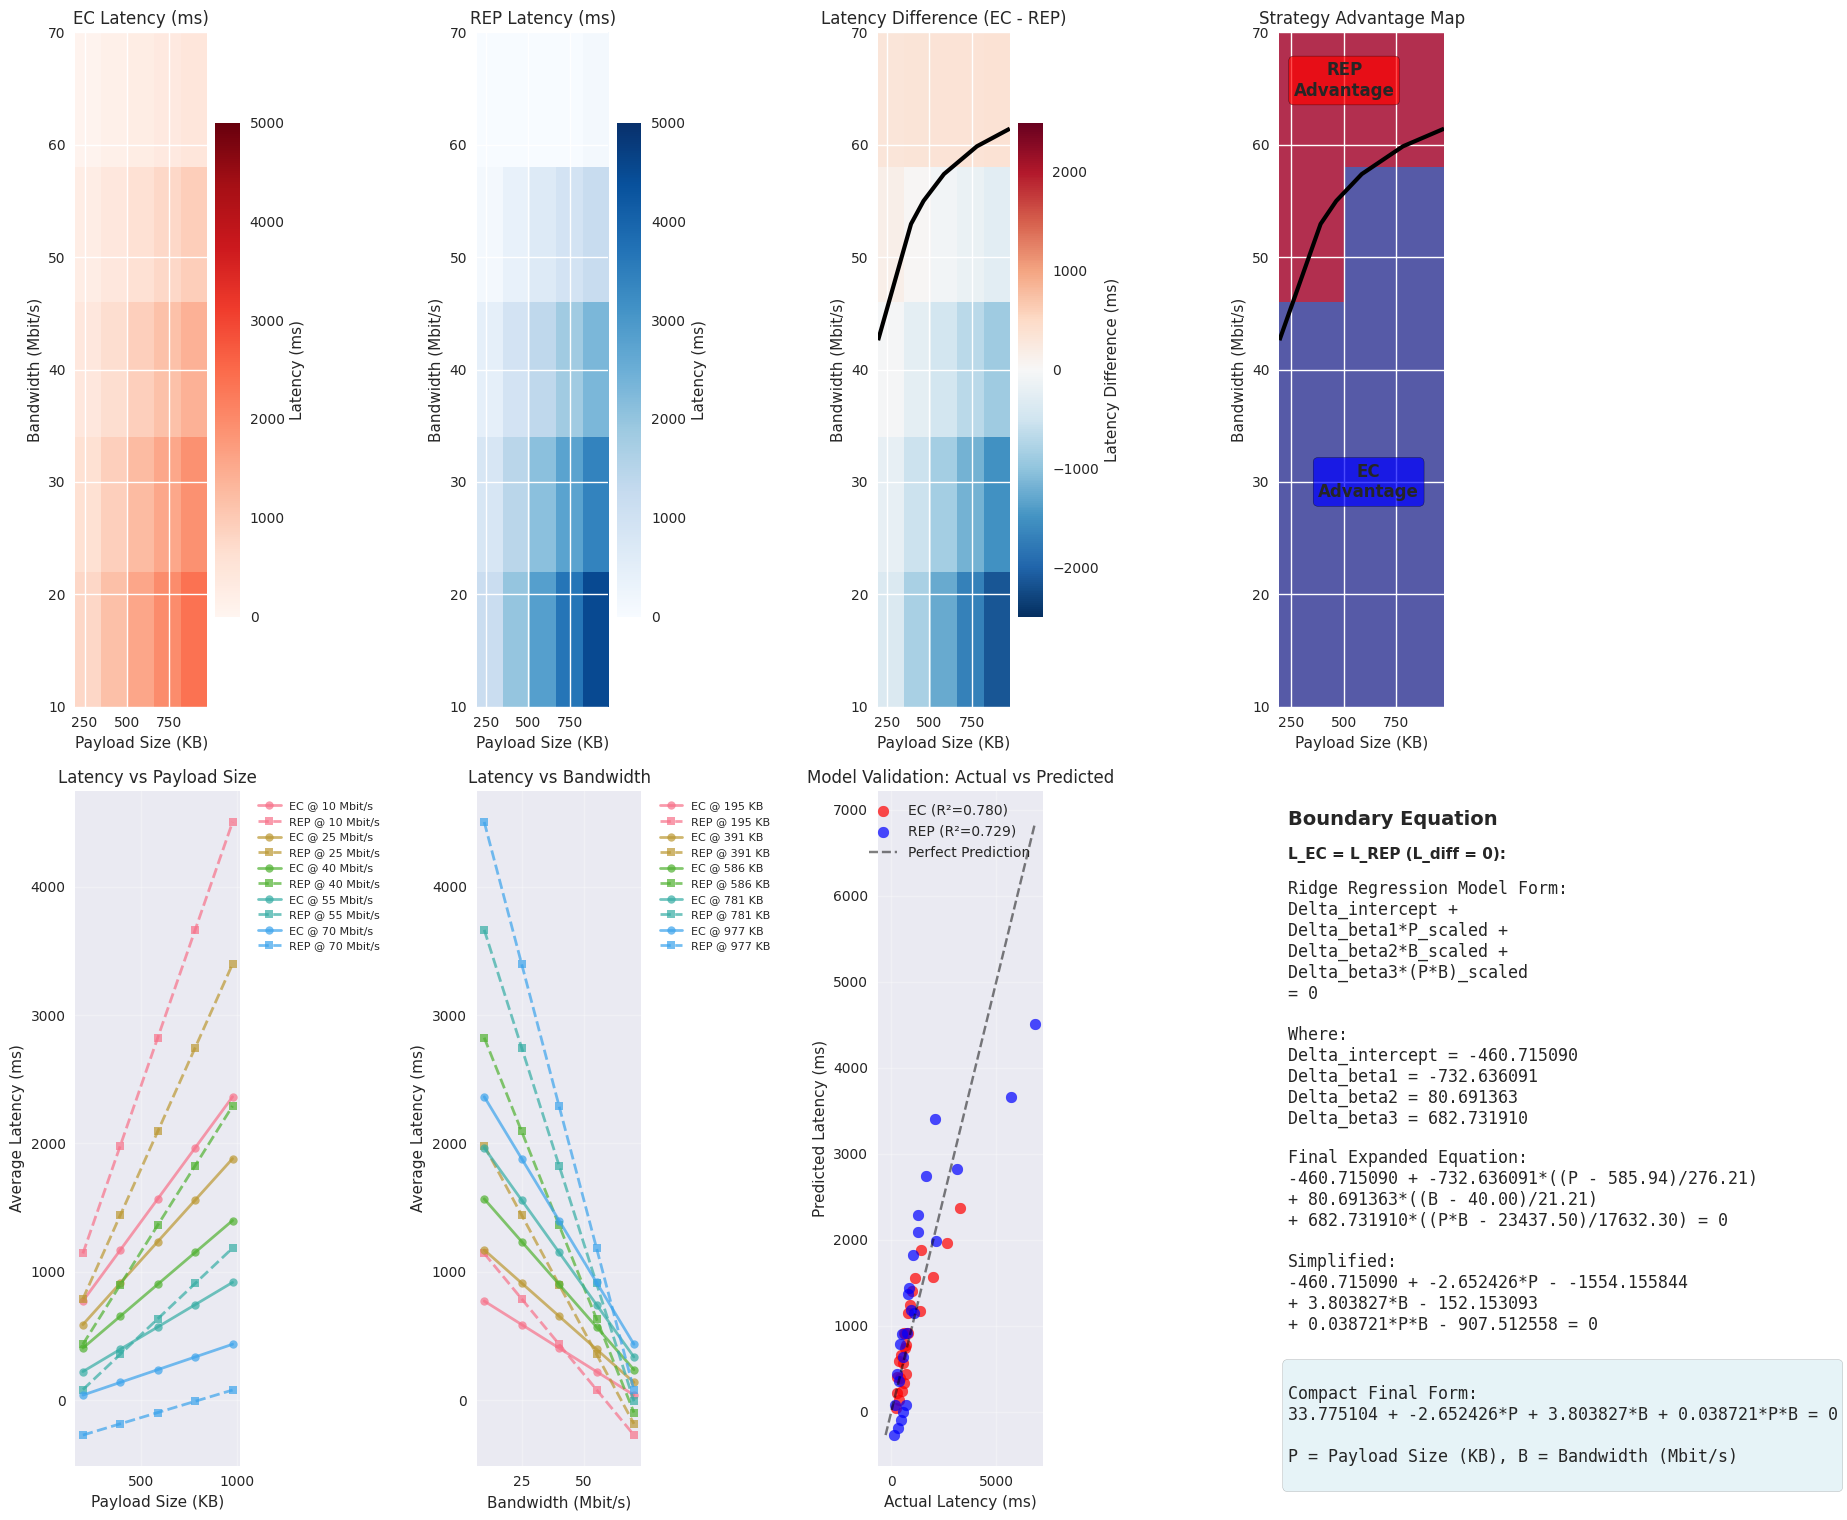

In [191]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. Actual Data Heatmap (EC Latency)
ax1 = fig.add_subplot(241)
im1 = ax1.imshow(L_ec, extent=[min(P_range_actual), max(P_range_actual), 
                                        min(B_range_actual), max(B_range_actual)], 
                aspect='auto', cmap='Reds', origin='lower', vmin=0, vmax=5000)
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Bandwidth (Mbit/s)')
ax1.set_title('EC Latency (ms)')
cbar = plt.colorbar(im1, ax=ax1)
cbar.set_label('Latency (ms)')

# 2. Actual Data Heatmap (REP Latency)
ax2 = fig.add_subplot(242)
im2 = ax2.imshow(L_rep, extent=[min(P_range_actual), max(P_range_actual), 
                                         min(B_range_actual), max(B_range_actual)], 
                aspect='auto', cmap='Blues', origin='lower', vmin=0, vmax=5000)
ax2.set_xlabel('Payload Size (KB)')
ax2.set_ylabel('Bandwidth (Mbit/s)')
ax2.set_title('REP Latency (ms)')
cbar = plt.colorbar(im2, ax=ax2)
cbar.set_label('Latency (ms)')

# 3. Difference Heatmap (no more artificial oscillations)
ax3 = fig.add_subplot(243)
im3 = ax3.imshow(L_diff, extent=[min(P_range_actual), max(P_range_actual), 
                                          min(B_range_actual), max(B_range_actual)], 
                aspect='auto', cmap='RdBu_r', origin='lower', vmin=-2500, vmax=2500)
ax3.contour(P_grid, B_grid, L_diff, levels=[0], colors='black', linewidths=3)
ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Bandwidth (Mbit/s)')
ax3.set_title('Latency Difference (EC - REP)')
cbar = plt.colorbar(im3, ax=ax3)
cbar.set_label('Latency Difference (ms)')

# 4. Strategy Advantage Map
ax4 = fig.add_subplot(244)
advantage = np.where(L_diff < 0, 1, -1)  # 1 for EC advantage, -1 for REP advantage
im4 = ax4.imshow(advantage, extent=[min(P_range_actual), max(P_range_actual), 
                                             min(B_range_actual), max(B_range_actual)], 
                aspect='auto', cmap='RdYlBu', origin='lower', alpha=0.8)
ax4.contour(P_grid, B_grid, L_diff, levels=[0], colors='black', linewidths=3)
ax4.set_xlabel('Payload Size (KB)')
ax4.set_ylabel('Bandwidth (Mbit/s)')
ax4.set_title('Strategy Advantage Map')

# Add proper text annotations for regions
ec_better = advantage == 1
rep_better = advantage == -1

if np.any(ec_better):
    ec_region = np.where(ec_better)
    ec_center_p = P_grid[ec_region].mean()
    ec_center_b = B_grid[ec_region].mean()
    ax4.text(ec_center_p, ec_center_b, 'EC\nAdvantage', fontsize=12, ha='center', va='center', 
             bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7), fontweight='bold')

if np.any(rep_better):
    rep_region = np.where(rep_better)
    rep_center_p = P_grid[rep_region].mean()
    rep_center_b = B_grid[rep_region].mean()
    ax4.text(rep_center_p, rep_center_b, 'REP\nAdvantage', fontsize=12, ha='center', va='center', 
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.7), fontweight='bold')

# 5. Performance by Payload Size (All Bandwidths)
ax5 = fig.add_subplot(245)
for i, bw in enumerate(B_range_actual):
    ec_latencies_bw = [L_ec[i, j] for j in range(len(P_range_actual))]
    rep_latencies_bw = [L_rep[i, j] for j in range(len(P_range_actual))]
    
    ax5.plot(P_range_actual, ec_latencies_bw, 'o-', color=f'C{i}', alpha=0.7, linewidth=2, 
             label=f'EC @ {bw} Mbit/s', markersize=6)
    ax5.plot(P_range_actual, rep_latencies_bw, 's--', color=f'C{i}', alpha=0.7, linewidth=2, 
             label=f'REP @ {bw} Mbit/s', markersize=6)

ax5.set_xlabel('Payload Size (KB)')
ax5.set_ylabel('Average Latency (ms)')
ax5.set_title('Latency vs Payload Size')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Performance by Bandwidth (All Payload Sizes)
ax6 = fig.add_subplot(246)
for i, payload in enumerate(P_range_actual):
    ec_latencies_payload = [L_ec[j, i] for j in range(len(B_range_actual))]
    rep_latencies_payload = [L_rep[j, i] for j in range(len(B_range_actual))]
    
    ax6.plot(B_range_actual, ec_latencies_payload, 'o-', color=f'C{i}', alpha=0.7, linewidth=2, 
             label=f'EC @ {payload:.0f} KB', markersize=6)
    ax6.plot(B_range_actual, rep_latencies_payload, 's--', color=f'C{i}', alpha=0.7, linewidth=2, 
             label=f'REP @ {payload:.0f} KB', markersize=6)

ax6.set_xlabel('Bandwidth (Mbit/s)')
ax6.set_ylabel('Average Latency (ms)')
ax6.set_title('Latency vs Bandwidth')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Model Validation: Actual vs Predicted
ax7 = fig.add_subplot(247)

# Get actual vs predicted values
actual_ec = ec_data['avg_latency_ms'].values
predicted_ec = ridge_ec.predict(X_ec_scaled)
actual_rep = rep_data['avg_latency_ms'].values
predicted_rep = ridge_rep.predict(X_rep_scaled)

ax7.scatter(actual_ec, predicted_ec, color='red', alpha=0.7, s=60, label=f'EC (R²={ec_r2_ridge:.3f})')
ax7.scatter(actual_rep, predicted_rep, color='blue', alpha=0.7, s=60, label=f'REP (R²={rep_r2_ridge:.3f})')

# Plot diagonal line for perfect prediction
min_val = min(actual_ec.min(), actual_rep.min(), predicted_ec.min(), predicted_rep.min())
max_val = max(actual_ec.max(), actual_rep.max(), predicted_ec.max(), predicted_rep.max())
ax7.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')

ax7.set_xlabel('Actual Latency (ms)')
ax7.set_ylabel('Predicted Latency (ms)')
ax7.set_title('Model Validation: Actual vs Predicted')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Strategy Advantage Boundary Equation
ax8 = fig.add_subplot(248)
ax8.axis('off')

# Calculate contour equation coefficients from Ridge models
# L_diff = L_ec - L_rep = 0 (contour boundary)
# Both models: Latency = intercept + coef[0]*P_scaled + coef[1]*B_scaled + coef[2]*(P*B)_scaled

# Get scaling parameters
ec_means = scaler_ec.mean_
ec_scales = scaler_ec.scale_
rep_means = scaler_rep.mean_
rep_scales = scaler_rep.scale_

# Difference in intercepts
delta_intercept = ec_intercept_ridge - rep_intercept_ridge

# Difference in coefficients
delta_coef = ec_coefficients_ridge - rep_coefficients_ridge

ax8.text(0.05, 0.95, 'Boundary Equation', fontsize=14, fontweight='bold', 
         transform=ax8.transAxes)

ax8.text(0.05, 0.90, 'L_EC = L_REP (L_diff = 0):', fontsize=11, fontweight='bold',
         transform=ax8.transAxes)

# Model form equation
model_form = f"""
Ridge Regression Model Form:
Delta_intercept + \nDelta_beta1*P_scaled + \nDelta_beta2*B_scaled + \nDelta_beta3*(P*B)_scaled \n= 0

Where:
Delta_intercept = {delta_intercept:.6f}
Delta_beta1 = {delta_coef[0]:.6f}
Delta_beta2 = {delta_coef[1]:.6f}  
Delta_beta3 = {delta_coef[2]:.6f}
"""

ax8.text(0.05, 0.90, model_form, fontsize=12, fontfamily='monospace', 
         transform=ax8.transAxes, verticalalignment='top')

# Final expanded equation with actual values
final_equation = f"""
Final Expanded Equation:
{delta_intercept:.6f} + {delta_coef[0]:.6f}*((P - {ec_means[0]:.2f})/{ec_scales[0]:.2f}) 
+ {delta_coef[1]:.6f}*((B - {ec_means[1]:.2f})/{ec_scales[1]:.2f}) 
+ {delta_coef[2]:.6f}*((P*B - {ec_means[2]:.2f})/{ec_scales[2]:.2f}) = 0

Simplified:
{delta_intercept:.6f} + {delta_coef[0]/ec_scales[0]:.6f}*P - {delta_coef[0]*ec_means[0]/ec_scales[0]:.6f}
+ {delta_coef[1]/ec_scales[1]:.6f}*B - {delta_coef[1]*ec_means[1]/ec_scales[1]:.6f}
+ {delta_coef[2]/ec_scales[2]:.6f}*P*B - {delta_coef[2]*ec_means[2]/ec_scales[2]:.6f} = 0
"""

ax8.text(0.05, 0.50, final_equation, fontsize=12, fontfamily='monospace', 
         transform=ax8.transAxes, verticalalignment='top')

# Calculate final coefficients for compact form
const_term = (delta_intercept - 
              delta_coef[0]*ec_means[0]/ec_scales[0] - 
              delta_coef[1]*ec_means[1]/ec_scales[1] - 
              delta_coef[2]*ec_means[2]/ec_scales[2])
p_coeff = delta_coef[0]/ec_scales[0]
b_coeff = delta_coef[1]/ec_scales[1]
pb_coeff = delta_coef[2]/ec_scales[2]

compact_equation = f"""
Compact Final Form:
{const_term:.6f} + {p_coeff:.6f}*P + {b_coeff:.6f}*B + {pb_coeff:.6f}*P*B = 0

P = Payload Size (KB), B = Bandwidth (Mbit/s)
"""

ax8.text(0.05, 0.15, compact_equation, fontsize=12, fontfamily='monospace', 
         transform=ax8.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Analyze performance regions for distributed systems insights
small_payload_high_bw = L_diff[3:, 0:2]  # High bandwidth, small payload
large_payload_low_bw = L_diff[0:2, 3:]   # Low bandwidth, large payload

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()